In [234]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import statsmodels.api as sm
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller#statiionaty검증
from pandas import datetime
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('D:\\data\\21.07_BMW미팅\\df_data\\07.17_21_월별_6브랜드_판매량.csv', encoding='utf-8')
df

,Unnamed: 0,브랜드,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,...,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
0,0,bmw,2415,3202,6164,6334,5373,5510,3188,4105,...,7252,5275,5320,5551,5749,5717,5660,6012,6113,6257
1,1,benz,6848,5534,6737,5758,5063,7783,5471,5267,...,6030,5958,6576,7186,9546,5918,5707,7597,8430,7690
2,2,audi,474,360,83,0,2,0,0,0,...,2022,2528,2527,2906,3109,2302,2362,2737,1320,229
3,3,volkswagen,0,0,0,0,0,0,0,0,...,881,872,1933,2677,2729,1236,1783,1628,1080,1358
4,4,mini,541,582,624,743,1013,841,794,826,...,1107,1108,890,940,1093,712,895,1224,1051,1095
5,5,volvo,436,570,675,542,596,693,624,602,...,336,801,1449,1267,1352,1198,1202,1251,1263,1264


In [3]:
df = df.drop(['Unnamed: 0'],axis=1)

In [4]:
bmw = df.loc[0]
bmw = bmw.reset_index()

In [5]:
benz = df.loc[1]
benz =benz.reset_index()

In [6]:
df2 = df.stack()

In [7]:
df2.reset_index()

,level_0,level_1,0
0,0,브랜드,bmw
1,0,2017-01-01,2415
2,0,2017-02-01,3202
3,0,2017-03-01,6164
4,0,2017-04-01,6334
...,...,...,...
319,5,2021-01-01,1198
320,5,2021-02-01,1202
321,5,2021-03-01,1251
322,5,2021-04-01,1263


In [8]:
result = pd.merge(bmw, benz, on=['index'], how='outer')
result.head()

,index,0,1
0,브랜드,bmw,benz
1,2017-01-01,2415,6848
2,2017-02-01,3202,5534
3,2017-03-01,6164,6737
4,2017-04-01,6334,5758
5,2017-05-01,5373,5063
6,2017-06-01,5510,7783
7,2017-07-01,3188,5471
8,2017-08-01,4105,5267
9,2017-09-01,5299,5606


In [9]:
result.columns = ['year','BMW','Benz']

In [10]:
result = result.drop(index=[0], axis=0)
result.head()

,year,BMW,Benz
1,2017-01-01,2415,6848
2,2017-02-01,3202,5534
3,2017-03-01,6164,6737
4,2017-04-01,6334,5758
5,2017-05-01,5373,5063
6,2017-06-01,5510,7783
7,2017-07-01,3188,5471
8,2017-08-01,4105,5267
9,2017-09-01,5299,5606
10,2017-10-01,4400,4539


In [11]:
# 데이터타입 바꾸기
result = result.astype({'BMW':'int'})
result = result.astype({'Benz':'int'})

In [12]:
# transacted_date, transacted_time 데이터 타입 string으로 인식하여 datetime64로 변환(column.dt.시간단위를 통해서 원하는 시간 부분을 추출해서 활용할 수 있음)
result['year'] = pd.to_datetime(result['year'])

In [13]:
result.head()

,year,BMW,Benz
1,2017-01-01,2415,6848
2,2017-02-01,3202,5534
3,2017-03-01,6164,6737
4,2017-04-01,6334,5758
5,2017-05-01,5373,5063
6,2017-06-01,5510,7783
7,2017-07-01,3188,5471
8,2017-08-01,4105,5267
9,2017-09-01,5299,5606
10,2017-10-01,4400,4539


In [21]:
#인덱스를 연도로 재설정
result.index = result['year']
result.set_index('year', inplace=True)
result.head()

,BMW,Benz
year,,
2017-01-01,2415,6848
2017-02-01,3202,5534
2017-03-01,6164,6737
2017-04-01,6334,5758
2017-05-01,5373,5063


<AxesSubplot:xlabel='year'>

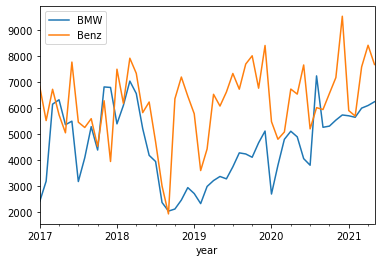

In [15]:
result.plot()

In [16]:
result = result.reset_index()
result.head()

,year,BMW,Benz
0,2017-01-01,2415,6848
1,2017-02-01,3202,5534
2,2017-03-01,6164,6737
3,2017-04-01,6334,5758
4,2017-05-01,5373,5063


In [17]:
result = result.drop('index', axis=1)

KeyError: "['index'] not found in axis"

<AxesSubplot:>

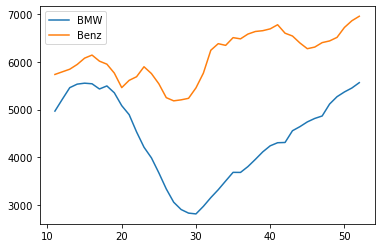

In [18]:
# BMW, Benz stationary 확인
timeseries = result
timeseries.rolling(12).mean().plot()#12개월평균

## Set up and plot the training data

In [28]:
# Benz data만 따로 
result_Benz = result['Benz']
result_Benz = result_Benz.reset_index()

In [121]:
len(result_Benz)

53

In [29]:
result_Benz.head()

,year,Benz
0,2017-01-01,6848
1,2017-02-01,5534
2,2017-03-01,6737
3,2017-04-01,5758
4,2017-05-01,5063


In [30]:
# Benz 인덱스 year 재설정
result_Benz.index = result_Benz['year']
result_Benz.set_index('year', inplace=True)
result_Benz.head()

,Benz
year,
2017-01-01,6848
2017-02-01,5534
2017-03-01,6737
2017-04-01,5758
2017-05-01,5063


In [31]:
# Bmw data만 따로 
result_BMW = result['BMW']
result_BMW = result_BMW.reset_index()

In [32]:
# BMW 인덱스 year 재설정
result_BMW.index = result_BMW['year']
result_BMW.set_index('year', inplace=True)
result_BMW.head()

,BMW
year,
2017-01-01,2415
2017-02-01,3202
2017-03-01,6164
2017-04-01,6334
2017-05-01,5373


In [184]:
len(Benz_test)

13

<AxesSubplot:xlabel='year'>

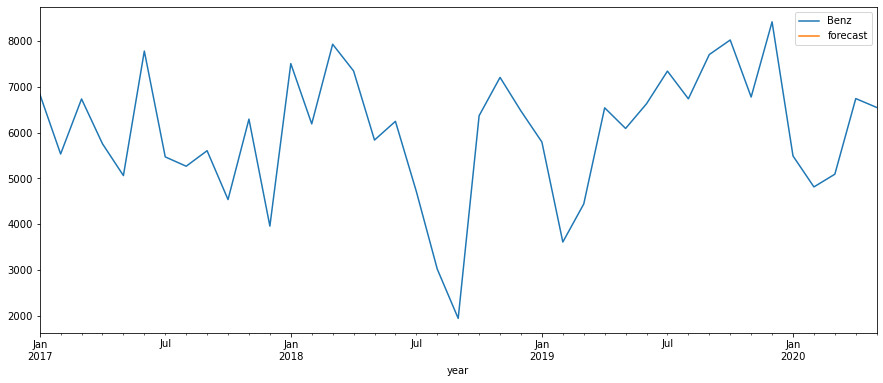

In [183]:
# Benz train data
Benz_train = result_Benz.loc[:'2020-05-01']
Benz_test = result_Benz.loc['2020-05-01':]
Benz_train.plot(figsize = (15,6))

<AxesSubplot:xlabel='year'>

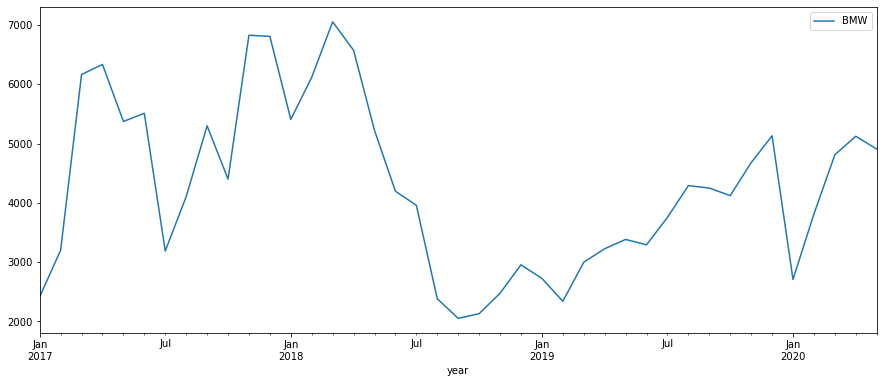

In [185]:
# BMW
BMW_train = result_BMW.loc[:'2020-05-01']
BMW_test = result_BMW.loc['2020-05-01':]
BMW_train.plot(figsize = (15,6))
# train data

<Figure size 432x288 with 0 Axes>

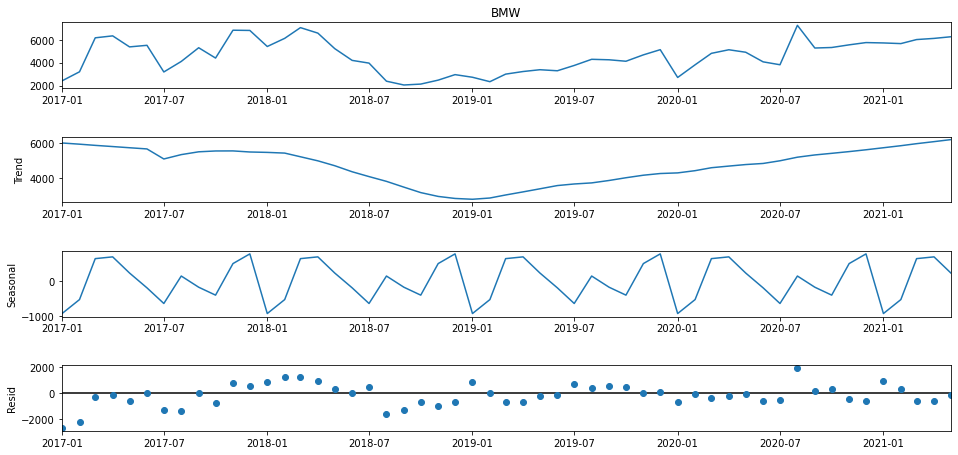

In [26]:
decomposition = seasonal_decompose(result_BMW['BMW'], model='additive', extrapolate_trend='freq')
# ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None
# index를 year로 재설정
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

<Figure size 432x288 with 0 Axes>

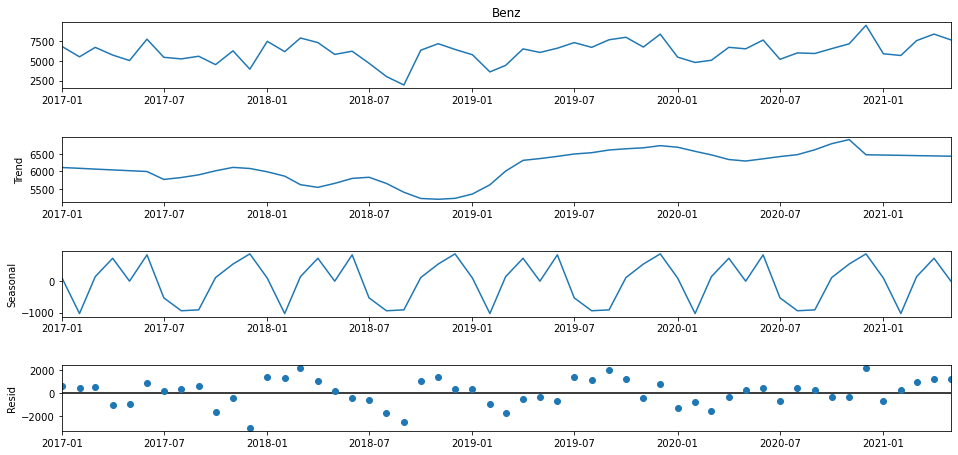

In [35]:
decomposition2 = seasonal_decompose(result_Benz['Benz'], model='additive', extrapolate_trend='freq')
fig = plt.figure()
fig = decomposition2.plot()
fig.set_size_inches(15,7)

## stationary 검증 방법 

In [27]:
# bmw
result2 = adfuller(result_BMW['BMW'])
result2

(-3.0147427042140826,
 0.03354036669069423,
 0,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 676.2432252758988)

In [39]:
#p-vslue 값이 0.03으로 정산성 확인
# stationary check 기능 함수
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <=0.05:
        print('Stationary{}'.format(result[1]))
    else:
        print('Non-stationary {}'.format(result[1]))

In [29]:
adf_check(result_BMW['BMW'])#정상성 획득

Stationary0.03354036669069423


In [40]:
result3 = adfuller(Benz_train['Benz'])
result3
#정상성 X

(-4.339244785237454,
 0.00037960797244027914,
 0,
 39,
 {'1%': -3.610399601308181,
  '5%': -2.939108945868946,
  '10%': -2.6080629651545038},
 506.7940370734625)

## differencing ##

In [35]:
Benz_train['1st diff'] = Benz_train['Benz'] - Benz_train['Benz'].shift(1)
Benz_train.head()

,Benz,1st diff
year,,
2017-01-01,6848,NaN
2017-02-01,5534,-1314.0
2017-03-01,6737,1203.0
2017-04-01,5758,-979.0
2017-05-01,5063,-695.0


In [62]:
# Nan 삭제
Benz_train['1st diff'].dropna(axis=0, how='any',inplace=False)

year
2017-01-01       NaN
2017-02-01   -1314.0
2017-03-01    1203.0
2017-04-01    -979.0
2017-05-01    -695.0
2017-06-01    2720.0
2017-07-01   -2312.0
2017-08-01    -204.0
2017-09-01     339.0
2017-10-01   -1067.0
2017-11-01    1757.0
2017-12-01   -2337.0
2018-01-01    3550.0
2018-02-01   -1317.0
2018-03-01    1740.0
2018-04-01    -583.0
2018-05-01   -1510.0
2018-06-01     409.0
2018-07-01   -1533.0
2018-08-01   -1696.0
2018-09-01   -1076.0
2018-10-01    4428.0
2018-11-01     837.0
2018-12-01    -735.0
2019-01-01    -677.0
2019-02-01   -2185.0
2019-03-01     831.0
2019-04-01    2101.0
2019-05-01    -451.0
2019-06-01     540.0
2019-07-01     713.0
2019-08-01    -605.0
2019-09-01     967.0
2019-10-01     318.0
2019-11-01   -1246.0
2019-12-01    1642.0
2020-01-01   -2929.0
2020-02-01    -677.0
2020-03-01     278.0
2020-04-01    1652.0
Name: 1st diff, dtype: float64

In [51]:
# Nan 평균 대체
Benz_train['1st diff'].fillna(Benz_train['1st diff'].mean())

year
2017-01-01      -2.641026
2017-02-01   -1314.000000
2017-03-01    1203.000000
2017-04-01    -979.000000
2017-05-01    -695.000000
2017-06-01    2720.000000
2017-07-01   -2312.000000
2017-08-01    -204.000000
2017-09-01     339.000000
2017-10-01   -1067.000000
2017-11-01    1757.000000
2017-12-01   -2337.000000
2018-01-01    3550.000000
2018-02-01   -1317.000000
2018-03-01    1740.000000
2018-04-01    -583.000000
2018-05-01   -1510.000000
2018-06-01     409.000000
2018-07-01   -1533.000000
2018-08-01   -1696.000000
2018-09-01   -1076.000000
2018-10-01    4428.000000
2018-11-01     837.000000
2018-12-01    -735.000000
2019-01-01    -677.000000
2019-02-01   -2185.000000
2019-03-01     831.000000
2019-04-01    2101.000000
2019-05-01    -451.000000
2019-06-01     540.000000
2019-07-01     713.000000
2019-08-01    -605.000000
2019-09-01     967.000000
2019-10-01     318.000000
2019-11-01   -1246.000000
2019-12-01    1642.000000
2020-01-01   -2929.000000
2020-02-01    -677.000000
2020-03

In [50]:
Benz_train.info()
# Nan 평균 대체

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2017-01-01 to 2020-04-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Benz      40 non-null     int32  
 1   1st diff  39 non-null     float64
dtypes: float64(1), int32(1)
memory usage: 800.0 bytes


In [41]:
adf_check(Benz_train['1st diff'].dropna())

Stationary9.808941411371826e-14


<AxesSubplot:xlabel='year'>

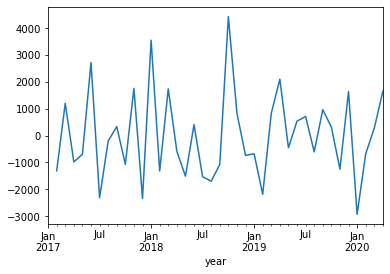

In [42]:
Benz_train['1st diff'].plot()

In [57]:
# d값은 1차 differencing이므로 1를 씀
# d = 1, D = 1

## differencing한 데이터로 acf, pacf 그리기

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

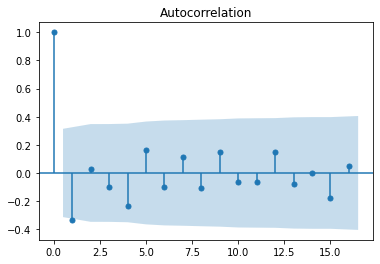

In [43]:
plot_acf(Benz_train['1st diff'].dropna());

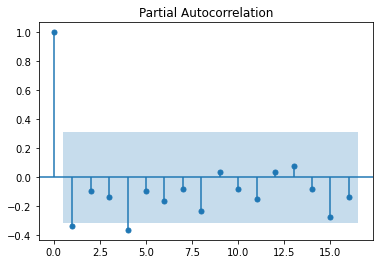

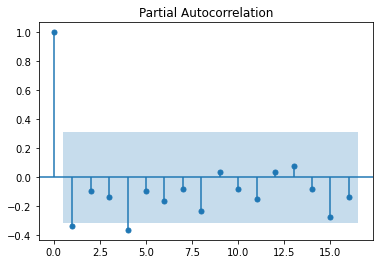

In [44]:
plot_pacf(Benz_train['1st diff'].dropna(), method='ywm')#partial AutoCorrelation

In [ ]:
# acf에서 음수 1개씩 나왔으므로 p, q값은 각 P=1. Q=1씀

## 하이퍼 파라미터 정하기

In [61]:
!pip install pmdarima

In [36]:
# auto_arima 함수로 자동 추출
# Benz
from pmdarima import auto_arima
stepwise_model = auto_arima(Benz_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=491.423, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=493.132, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=491.337, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=492.142, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=492.865, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=491.228, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=492.889, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=491.845, Time=0.05

In [193]:
# BMW
from pmdarima import auto_arima
stepwise_model = auto_arima(
BMW_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=480.426, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=471.580, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=482.199, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=472.129, Time=0.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=469.658, Time=0.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=470.489, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=470.564, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=471.597, Time=0.09

## ARIMA 학습 및 검증

## Benz 

In [46]:
Benz_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2017-01-01 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Benz    40 non-null     int32
dtypes: int32(1)
memory usage: 480.0 bytes


In [47]:
# 오류시 train data float64로 바꾸기
# Benz_train  = Benz_train.astype({'Benz':'float64'})
# How to fix numpy TypeError: Cannot cast ufunc subtract output from dtype(‘float64’) to dtype(‘int64’) with casting rule ‘same_kind’

In [101]:
model = ARIMA(Benz_train, order=(0,1,0))
# model = ARIMA(Benz_train, order=(0,1,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [102]:
bresult= model.fit(trend='c', full_output=True, disp=-1)

In [103]:
bresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Benz   No. Observations:                   39
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -343.759
Method:                           css   S.D. of innovations           1628.448
Date:                Fri, 16 Jul 2021   AIC                            691.517
Time:                        14:01:44   BIC                            694.844
Sample:                    02-01-2017   HQIC                           692.711
                         - 04-01-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6410    260.760     -0.010      0.992    -513.722     508.440
==============================================================================
"""

In [104]:
bresult

<AxesSubplot:xlabel='year'>

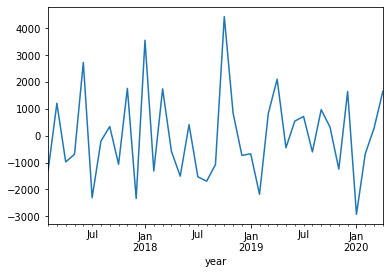

In [105]:
bresult.resid.plot()

<AxesSubplot:ylabel='Density'>

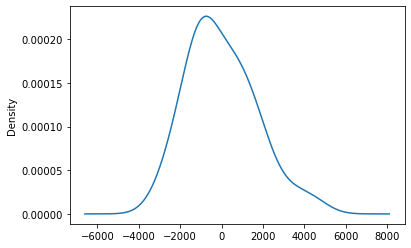

In [106]:
bresult.resid.plot(kind='kde')

## FC

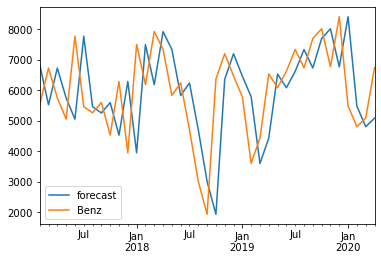

In [119]:
# 훈련이 잘됨
bresult.plot_predict(dynamic=False)
plt.show()

In [116]:
# Forecast
fc, se, conf  = bresult.forecast(steps=14, alpha=0.05)

In [109]:
# date1 = datetime(2021,6,1)
# date2 = datetime(2021,7,1)
# date3 = datetime(2021,8,1)
# date4 = datetime(2021,9,1)
# date5 = datetime(2021,10,1)

In [117]:
# Make as pandas series
# fc_series = pd.Series(fc, index=[date1,date2,date3,date4,date5])
fc_series = pd.Series(fc, index=Benz_test.index)
fc_series

year
2020-04-01    6742.358974
2020-05-01    6739.717949
2020-06-01    6737.076923
2020-07-01    6734.435897
2020-08-01    6731.794872
2020-09-01    6729.153846
2020-10-01    6726.512821
2020-11-01    6723.871795
2020-12-01    6721.230769
2021-01-01    6718.589744
2021-02-01    6715.948718
2021-03-01    6713.307692
2021-04-01    6710.666667
2021-05-01    6708.025641
dtype: float64

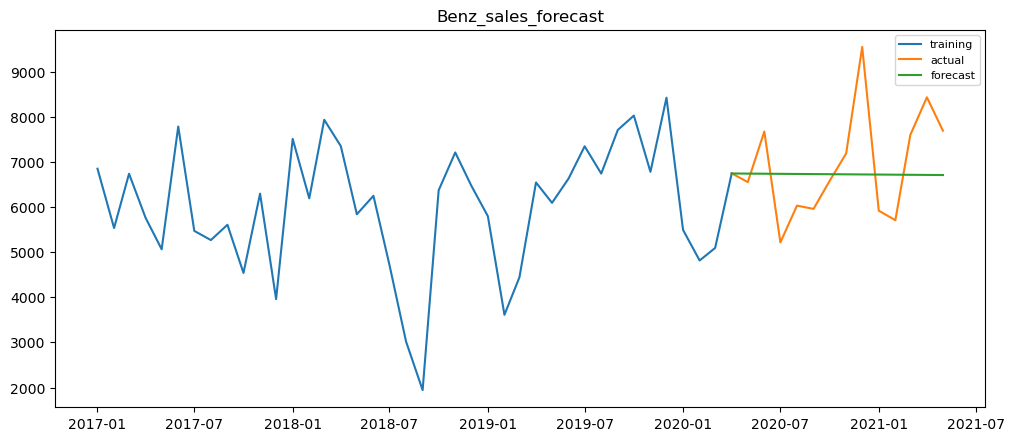

In [118]:
# plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Benz_train, label='training')
plt.plot(Benz_test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Benz_sales_forecast')
plt.legend(loc='upper right', fontsize=8)
plt.show()

## BMW

In [224]:
model = ARIMA(BMW_train, order=(0,1,0))
# model = ARIMA(Benz_train, order=(0,1,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [225]:
BMW_result= model.fit(trend='c', full_output=True, disp=-1)

In [226]:
BMW_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.BMW   No. Observations:                   40
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -334.972
Method:                           css   S.D. of innovations           1048.754
Date:                Fri, 16 Jul 2021   AIC                            673.944
Time:                        15:32:02   BIC                            677.321
Sample:                    02-01-2017   HQIC                           675.165
                         - 05-01-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3000    165.823      0.376      0.707    -262.706     387.306
==============================================================================
"""

In [222]:
BMW_train  = BMW_train.astype({'BMW':'float64'})

In [241]:
fc, se, conf  = BMW_result.forecast(steps=13, alpha=0.05)

In [242]:
fc_series2 = pd.Series(fc, index=BMW_test.index)
fc_series2

year
2020-05-01    4969.3
2020-06-01    5031.6
2020-07-01    5093.9
2020-08-01    5156.2
2020-09-01    5218.5
2020-10-01    5280.8
2020-11-01    5343.1
2020-12-01    5405.4
2021-01-01    5467.7
2021-02-01    5530.0
2021-03-01    5592.3
2021-04-01    5654.6
2021-05-01    5716.9
dtype: float64

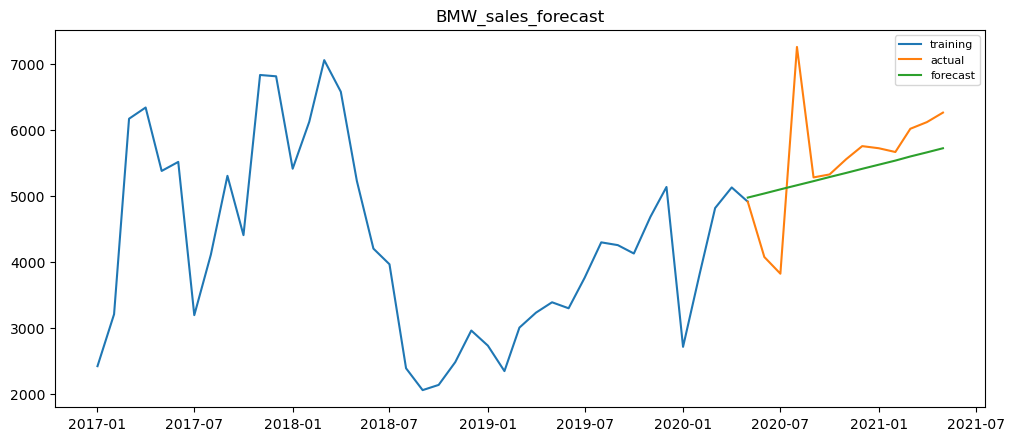

In [243]:
# plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(BMW_train, label='training')
plt.plot(BMW_test, label='actual')
plt.plot(fc_series2, label='forecast')

plt.title('BMW_sales_forecast')
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [239]:
from pandas.tseries.offsets import DateOffset
future_dates3=[result_BMW.index[-1]+ DateOffset(months=x)for x in range(0,14)]
future_datest_df3=pd.DataFrame(index=future_dates3[1:],columns=result_BMW.columns)

future_datest_df3.tail()

future_df3=pd.concat([result_BMW,future_datest_df3])

## SARIMAX 학습 및 검증

## Benz

In [120]:
len(Benz_train)

40

In [147]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(Benz_train['Benz'],order=(0, 1, 0),seasonal_order=(0,1,1,12))
results=model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [148]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Benz   No. Observations:                   40
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -243.614
Date:                              Fri, 16 Jul 2021   AIC                            491.228
Time:                                      14:44:43   BIC                            493.820
Sample:                                  01-01-2017   HQIC                           491.999
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.4726      0.213     -2.221      0.026      -0.890      -0.055
sigma2      3.903e+06   9.53e+05      4.097      0.000    2.04e+06    5.77e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.17   Prob(JB):                         0.75
Heteroskedasticity (H):               1.18   Skew:                             0.12
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='year'>

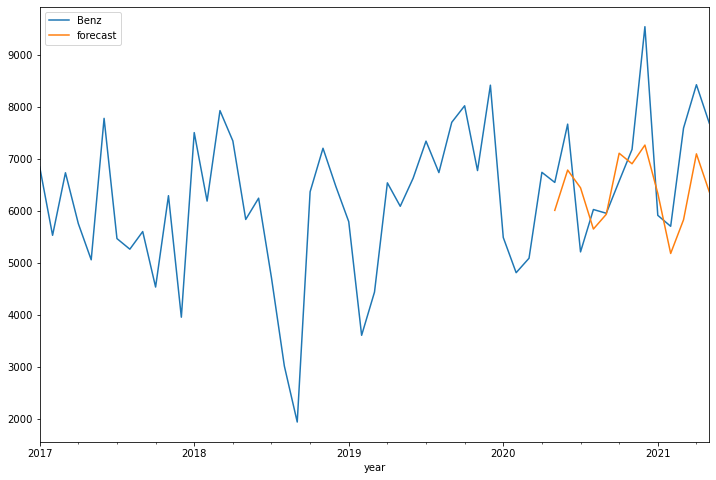

In [161]:
result_Benz['forecast']=results.predict(start=40,end=53,dynamic=True)
result_Benz[['Benz','forecast']].plot(figsize=(12,8))

## 2021년 5월 이후 date index 나타내기 

In [186]:
from pandas.tseries.offsets import DateOffset
future_dates=[result_Benz.index[-1]+ DateOffset(months=x)for x in range(0,14)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=result_Benz.columns)

future_datest_df.tail()

future_df=pd.concat([result_Benz,future_datest_df])

In [187]:
len(future_df)

66

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:>

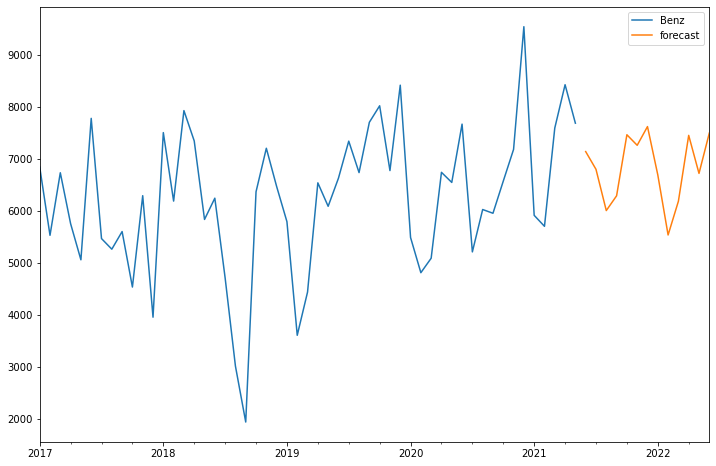

In [188]:
future_df['forecast'] = results.predict(start = 53, end = 66, dynamic= True)
future_df[['Benz', 'forecast']].plot(figsize=(12, 8))

## BMW

In [214]:
import statsmodels.api as sm
model2=sm.tsa.statespace.SARIMAX(BMW_train['BMW'],order=(0, 1, 0),seasonal_order=(1,1,0,12))
results2=model2.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [215]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                BMW   No. Observations:                   41
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -232.829
Date:                            Fri, 16 Jul 2021   AIC                            469.658
Time:                                    15:26:18   BIC                            472.322
Sample:                                01-01-2017   HQIC                           470.472
                                     - 05-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6086      0.126     -4.827      0.000      -0.856      -0.361
sigma2      9.868e+05   3.47e+05      2.844      0.004    3.07e+05    1.67e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.82   Prob(JB):                         0.76
Heteroskedasticity (H):               0.60   Skew:                             0.05
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='year'>

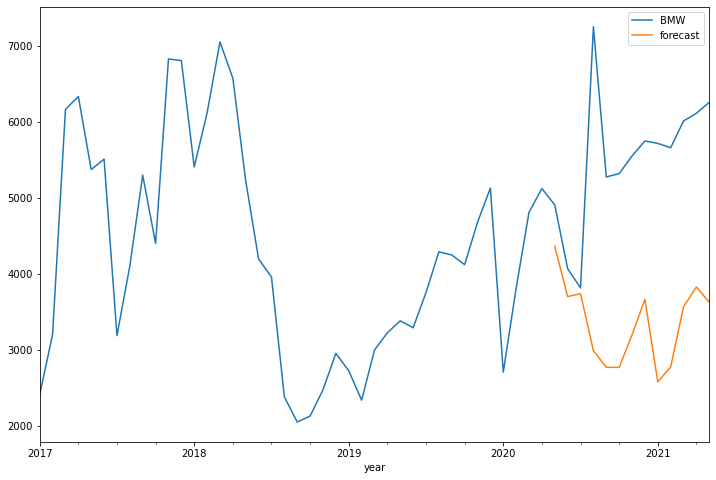

In [216]:
result_BMW['forecast']=results2.predict(start=40,end=53,dynamic=True)
result_BMW[['BMW','forecast']].plot(figsize=(12,8))

In [212]:
from pandas.tseries.offsets import DateOffset
future_dates2=[result_BMW.index[-1]+ DateOffset(months=x)for x in range(0,14)]
future_datest_df2=pd.DataFrame(index=future_dates2[1:],columns=result_BMW.columns)

future_datest_df2.tail()

future_df2=pd.concat([result_BMW,future_datest_df2])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:>

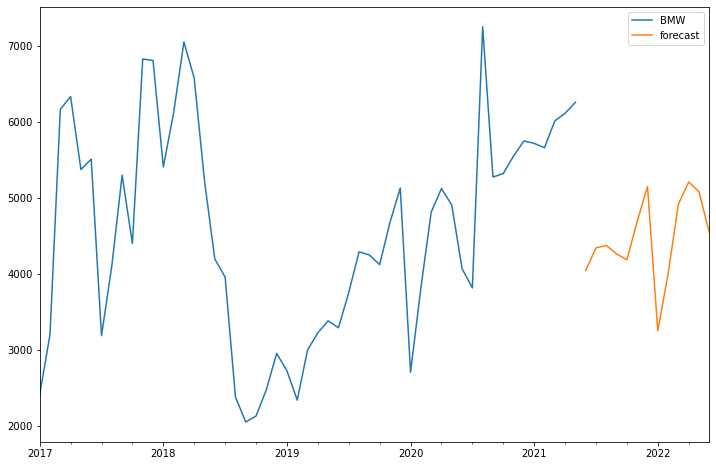

In [213]:
future_df2['forecast'] = results2.predict(start = 53, end = 66, dynamic= True)
future_df2[['BMW', 'forecast']].plot(figsize=(12, 8))

## Benz는 SARIMA 모델이 더 적합, BMW는 ARIMA 모델이 더 적합

## Benz, BMW 같이 그리기

## 정확도 평가

In [189]:
len(future_df['forecast'][53:66])

13

In [191]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from math import sqrt
rmse(Benz_test['Benz'], future_df['forecast'][53:66])
# root_Mean_squared_error 평균 제곱근 오차

1116.7981512220297

In [192]:
mean_squared_error(Benz_test['Benz'], future_df['forecast'][53:66])
#평균제곱오차

1247238.1105729437